In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('indicator_data_download_20250626.csv')

In [3]:
df.head()

,Indicator Name,What Is This Indicator,Location Type,Location,Indicator Rate Value,Indicator Rate Value Units,Rate Lower Confidence Interval,Rate Upper Confidence Interval,Indicator Count Value,Indicator Count Value Units,...,Breakout Rate Value,Breakout Rate Value Units,Breakout Rate Lower Confidence Interval,Breakout Rate Upper Confidence Interval,Breakout Count Value,Breakout Count Value Units,Breakout Count Lower Confidence Interval,Breakout Count Upper Confidence Interval,Breakout Unstable,Breakout Footer
0,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,556.7,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
1,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,717.1,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
2,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,550.0,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
3,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,497.5,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN
4,Tourism Economic Impact,The economic impact of visitor spending activi...,County,Washoe,3325.1,Million Dollars,NaN,NaN,NaN,NaN,...,616.2,Million Dollars,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 29 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Indicator Name                            25 non-null     object 
 1   What Is This Indicator                    25 non-null     object 
 2   Location Type                             25 non-null     object 
 3   Location                                  25 non-null     object 
 4   Indicator Rate Value                      25 non-null     float64
 5   Indicator Rate Value Units                25 non-null     object 
 6   Rate Lower Confidence Interval            0 non-null      float64
 7   Rate Upper Confidence Interval            0 non-null      float64
 8   Indicator Count Value                     0 non-null      float64
 9   Indicator Count Value Units               0 non-null      float64
 10  Count Lower Confidence Interval         

In [5]:
df['Indicator Name'].value_counts()

Indicator Name
Tourism Economic Impact    25
Name: count, dtype: int64

In [6]:
df['Indicator Rate Value Units'].value_counts()

Indicator Rate Value Units
Million Dollars    25
Name: count, dtype: int64

In [7]:
df['Breakout Subcategory'].head()

0    Food & beverage
1             Gaming
2            Lodging
3         Recreation
4             Retail
Name: Breakout Subcategory, dtype: object

In [8]:
df['Period of Measure'].value_counts()

Period of Measure
2023    6
2022    6
2021    6
2020    1
2019    1
2018    1
2017    1
2016    1
2015    1
2014    1
Name: count, dtype: int64

In [19]:
totals_by_year = {}

for ind, row in df.iterrows():
    year = row['Period of Measure']
    value = row['Indicator Rate Value']

    if year in totals_by_year:
        totals_by_year[year] += value
    else:
        totals_by_year[year] = value

yearly_totals = pd.DataFrame(list(totals_by_year.items()), columns = ['year', 'value'])

In [23]:
yearly_totals = yearly_totals.sort_values(by = 'year', ascending = True)
yearly_totals

,year,value
9,2014,2428.4
8,2015,2547.6
7,2016,2662.2
6,2017,2747.6
5,2018,2831.4
4,2019,2925.5
3,2020,1919.1
2,2021,17032.8
1,2022,18787.2
0,2023,19950.6


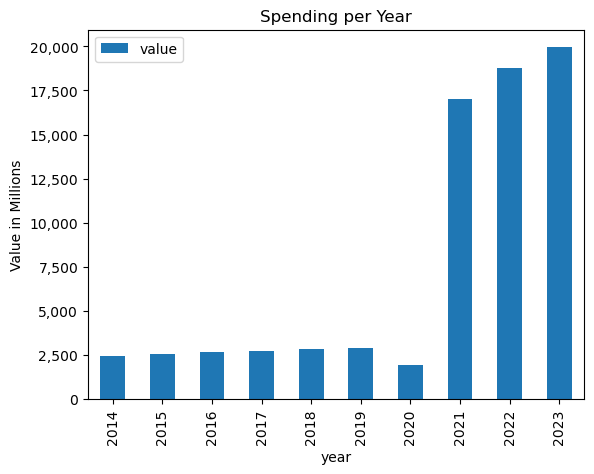

In [32]:
fig, ax = plt.subplots()

yearly_totals.plot(x = 'year', y = 'value', kind = 'bar', ax = ax)

ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, p: format(int(x), ','))) # format labels

ax.set_title('Spending per Year')
ax.set_ylabel('Value in Millions')
plt.show();